In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
import fastText
EMBEDDING_DIM = 300  # Word vector dimensionality
fasttext_model = fastText.load_model("../input/fasttext_300features_40minwords_10context.bin")

Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['i loathed this film  the original phantasm had such wonderful ambiance and mystery  like many  seven  zero s horror flicks  it looked and felt like some creepy  unfinished documentary  phantasm ii  from the late  eight  zero s  pumped up the action  but maintained this nice attention to mood  sadly  phantasm iii is just awful  it tediously explains all of the weird happenings in the previous films  which diminishes rather than expands their power  it shamelessly degrades imagery from the first phantasm like a cheap reenactment of the original  there are so many flying spheres in this movie that they seem more like household pests than menacing death orbs  hundreds hang from the ceiling like christmas balls swaying in the draft  didn t anyone   the prop master  the dp  the editor  the director   notice or care that they looked so crummy  even worse  phantasm iii presents one corny  unfunny joke after another  how different from the intensity of the first film  the original phantasm us

In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [11]:
print(word_index.items()[0])

('fawn', 29637)


In [15]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
# Null word embeddings is one because index 0 does not match any tokens. keras tokenizer uses 1-based index.

Null word embeddings: 1


In [16]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [17]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [19]:
def cnn_rnn_model(dropout_cnn=0.5, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [20]:
model = cnn_rnn_model()

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 249, 32)           2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [22]:
# batch_size: number of samples per gradient update
model.fit(x_train, y_train, batch_size=64, epochs=6, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/6
20000/20000 [==============================] - 293s 15ms/step - loss: 0.4903 - acc: 0.7638 - val_loss: 0.3693 - val_acc: 0.8466
Epoch 2/6
20000/20000 [==============================] - 296s 15ms/step - loss: 0.3241 - acc: 0.8684 - val_loss: 0.3116 - val_acc: 0.8732
Epoch 3/6
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2974 - acc: 0.8821 - val_loss: 0.3059 - val_acc: 0.8768
Epoch 4/6
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2704 - acc: 0.8951 - val_loss: 0.2743 - val_acc: 0.8942
Epoch 5/6
20000/20000 [==============================] - 291s 15ms/step - loss: 0.2524 - acc: 0.9007 - val_loss: 0.2751 - val_acc: 0.8906
Epoch 6/6
20000/20000 [==============================] - 295s 15ms/step - loss: 0.2448 - acc: 0.9031 - val_loss: 0.2570 - val_acc: 0.8964


In [23]:
y_test_pred = model.predict(x_test)

In [24]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [30]:
print("The AUC score for CNN-BiLSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.90132.


In [31]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm_fasttext.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm_fasttext.csv"

Wrote to cnn_bilstm_fasttext.csv


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

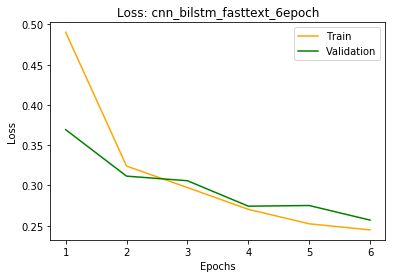

In [3]:
loss = [0.4903, 0.3241, 0.2974, 0.2704, 0.2524, 0.2448]
val_loss = [0.3693, 0.3116, 0.3059, 0.2743, 0.2751, 0.2570]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_fasttext_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

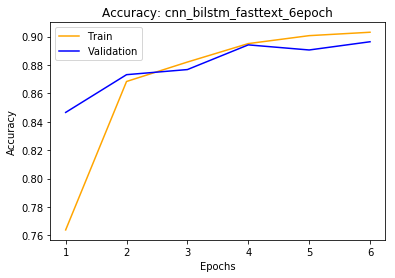

In [4]:
acc = [0.7638, 0.8684, 0.8821, 0.8951, 0.9007, 0.9031]
val_acc = [0.8466, 0.8732, 0.8768, 0.8942, 0.8906, 0.8964]

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_fasttext_6epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()